In [1]:
import numpy as np
import pickle
from TFHelp import *
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
file = open("TFA_CSMatrices/learnedTFAvalSignConst.csv","r") #TFA matrix


In [3]:

#read in matrix
delimiter = ","
matrix = [[float(y) for y in x.split(delimiter)] for x in file.readlines()]

TFAHelp = TFAHelper(matrix)


#read in columns labels of gene expression file
columnLabelFile = "deleteome_all_mutants_controls.tsv"
geneExpression = open(columnLabelFile,"r")
columnLabels = geneExpression.readline().split("\t")[3:]

#get gene KO from column labels
realColumnLabels = []
perSample = 0
for column in columnLabels:
	if perSample == 2:
		try:
			column.index("vs. wt")
			realColumnLabels.append(str.lower(column.replace(" vs. wt","")[:-4])) 
		except:
			realColumnLabels.append(str.lower(column.replace(" vs wt","")[:-4]))
		perSample = 0 
	else:
		perSample += 1

#get kinases/phosphotases of interest
kinasesOfInterestFile = "finalKinasesToDetermineInteractions2.txt"

#common to systematic gene conversion dictionaries for kinases/phosphotases
common2SystematicKinases = {x.rstrip().split(" ")[0]:x.rstrip().split(" ")[-1] for x in open(kinasesOfInterestFile,"r").readlines()[1:]}
systematic2commonKinases = {value:key for key,value in common2SystematicKinases.items()}


columnsOfInterest = []
columnsOfInterestNames = []
for x in range(len(realColumnLabels)):
	if realColumnLabels[x] in common2SystematicKinases or realColumnLabels[x] in systematic2commonKinases:
		columnsOfInterest.append(x)
		if realColumnLabels[x] in common2SystematicKinases: 
			columnsOfInterestNames.append(common2SystematicKinases[realColumnLabels[x]])
		else:
			columnsOfInterestNames.append(realColumnLabels[x])

#confirm the correct number of columns are found 
print("Number of expected kinases/phosphatases: ",len(common2SystematicKinases))
print("Number of found kinases/phosphotases: " ,len(columnsOfInterestNames))

#add WT TFA to matrix of interest and generate matrix
columnsOfInterestNames.append("wt")
wt = [matrix[row][-1] for row in range(len(matrix))] 
matrix = [[matrix[row][col] for col in columnsOfInterest]+[wt[row]] for row in range(len(matrix)-1)]

#append pseudoTF 
matrix.append([1 for _ in range(len(matrix[0]))])

#validate matrix dimensions, should be (45,52)
print(len(matrix),len(matrix[0]))

#output relevant matrix 
TFAHelp.writeMatrix2csv(matrix,open("TFAFoundMatrix.csv","w"))

#write kinase column names
file = open("kinaseNamesForColumns","w")
[file.write(kinase+"\n") for kinase in columnsOfInterestNames]
file.close()

#get row labels for matrix
rowLabelFile = "TFListZev.csv"
TFs = [str.lower(x.rstrip())[1:-1] for x in open(rowLabelFile,"r").readlines()]
print(len(TFs)) #should be 44


('Number of expected kinases/phosphatases: ', 51)
('Number of found kinases/phosphotases: ', 51)
(45, 52)
44


In [4]:
#get expected interactions
expectedResults = [x.rstrip().split()[:3] for x in open("../SelectedData/kinaseTFInteractionsWQuantititation.txt","r").readlines()[1:]]
expectedResults = [[kinase+"_"+tf,score] for kinase,tf,score in expectedResults]
interactions = {x[0]:-1 for x in expectedResults}
for inter,score in expectedResults:
    if score == "BG:": score = 2.0 #set biogrid scores to log liklihood of 2.0
    interactions[inter] = float(score)

#load gene expression
geneExpression = pickle.load(open("geneExpressionForKinaseOfInterest.pkl","rb"))
geneExpression = {TFAHelp.common2SystematicName[key]:value for key,value in geneExpression.items() if key in TFAHelp.common2SystematicName}
for kinase in geneExpression:
	for type in geneExpression[kinase]:
		geneExpression[kinase][type] = {TFAHelp.common2SystematicName[key]:value for key,value in geneExpression[kinase][type].items() if key in TFAHelp.common2SystematicName}

kinases = list(columnsOfInterestNames)

['ykl139w_ynl027w', 'yor061w_ykl185w', 'ykl139w_ylr403w', 'ykl139w_ykl185w', 'ykl139w_yjl056c']
('Number of Found Significant Interactions: ', 58, 5, '; alpha = ', 0.05, -2.0048270563155617, 1.9522685976587155)
(0.0038094122351395514, 0.645332699294637)


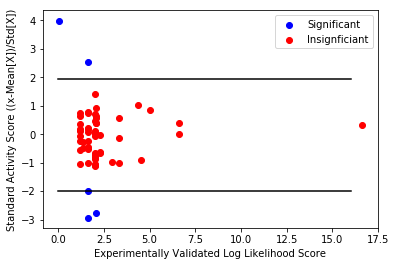

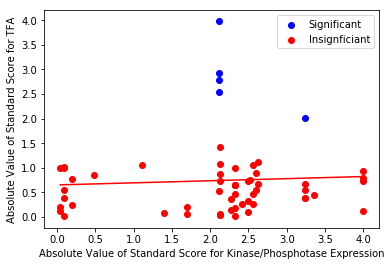

In [5]:
#transform matrix

normalizedMatrix  = TFAHelp.standardScore(matrix[:-1])

#match interactions
interactionsFound = {x[0]:-1 for x in expectedResults}
for tf in range(len(normalizedMatrix)-1):
    for kinase in range(len(normalizedMatrix[tf])):
        if kinases[kinase]+"_"+TFs[tf] in interactions:
            interactionsFound[kinases[kinase]+"_"+TFs[tf]] = normalizedMatrix[tf][kinase]

allInteractions = TFAHelp.flatten(TFAHelp.standardScore(TFAHelp.TFAWholeMatrix[:-1]))
pvalsInteractionsFound = TFAHelp.getPValuesForInteractions(interactionsFound,allInteractions)
        
alpha = .05 #fixed to find signfificance #.16 finds 2 significant 

uniqueInteractions = [inter for inter in interactions]

significantFoundInteractions,insignificantInteractions = TFAHelp.catagorizeInteractionsForSignificance(alpha,pvalsInteractionsFound)
print(significantFoundInteractions)


plt.scatter([interactions[inter] for inter in significantFoundInteractions],[interactionsFound[inter] for inter in significantFoundInteractions],c = "b",label = "Significant")
plt.scatter([interactions[inter] for inter in insignificantInteractions],[interactionsFound[inter] for inter in insignificantInteractions],c="r",label = "Insignficiant")
plt.legend()
expectedInteractionLogScores = [interactions[inter] for inter in uniqueInteractions]
minLogScore = int(min(expectedInteractionLogScores))
maxLogScore = int(max(expectedInteractionLogScores)+1)

allInteractions.sort(reverse=True)
scoreCutoffHigh = allInteractions[int(np.floor((alpha/2)*len(allInteractions)))]
scoreCutoffLow = allInteractions[-1*int(np.ceil((alpha/2)*len(allInteractions)))]

print("Number of Found Significant Interactions: ",len(uniqueInteractions),len(significantFoundInteractions),"; alpha = ",alpha,scoreCutoffLow,scoreCutoffHigh)


plt.plot([x for x in range(minLogScore,maxLogScore)],[scoreCutoffHigh for _ in range(minLogScore,maxLogScore)],c="black")
plt.plot([x for x in range(minLogScore,maxLogScore)],[scoreCutoffLow for _ in range(minLogScore,maxLogScore)],c="black")

plt.xlabel("Experimentally Validated Log Likelihood Score")
plt.ylabel("Standard Activity Score ((x-Mean[X])/Std[X])") 


GEImpact = {inter:-1 for inter in uniqueInteractions}
xvals = []
yvals = []
for inter in uniqueInteractions:
	kinase = inter.split("_")[0]
	allScoresForKinase = [geneExpression[kinase2]["expression"][kinase] for kinase2 in geneExpression]
	kianseStdScore = (geneExpression[kinase]["expression"][kinase] - np.mean(allScoresForKinase))/np.std(allScoresForKinase)
	GEImpact[inter] = kianseStdScore
	xvals.append(abs(kianseStdScore))
	yvals.append(abs(interactionsFound[inter]))

plt.figure()
plt.scatter([abs(GEImpact[inter]) for inter in significantFoundInteractions],[abs(interactionsFound[inter]) for inter in significantFoundInteractions],c = "b",label = "Significant")
plt.scatter([abs(GEImpact[inter]) for inter in insignificantInteractions],[abs(interactionsFound[inter]) for inter in insignificantInteractions],c="r",label = "Insignficiant")
plt.legend()
plt.xlabel("Absolute Value of Standard Score for Kinase/Phosphotase Expression")
plt.ylabel("Absolute Value of Standard Score for TFA")

positions = range(len(xvals))
positions.sort(key=lambda x: xvals[x])
xvals = [xvals[x] for x in positions]
yvals = [yvals[x] for x in positions]
slope,intercept,r,pvalue,_ = stats.linregress(xvals, yvals)
plt.plot(xvals,[x*slope+intercept for x in xvals],"r-")
print(r**2,pvalue)


['yor061w_ykl185w', 'ykl139w_ylr403w', 'ypl031c_ykl185w', 'ykl139w_ykl185w']
('Number of Found Significant Interactions: ', 58, 4, '; alpha = ', 0.05, 0.23232376456848114)
(0.043495347950369224, 0.11616743636361705)


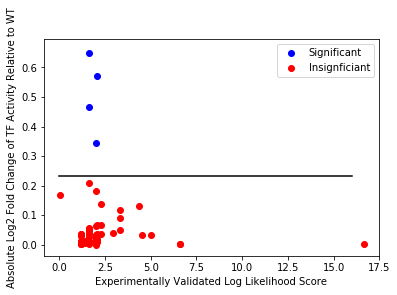

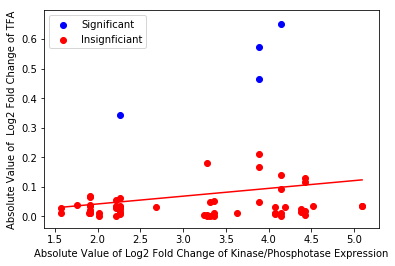

In [6]:
normalizedMatrix  = TFAHelp.absoluteLog2FoldChange(matrix)

#match interactions
interactionsFound = {x[0]:-1 for x in expectedResults}
for tf in range(len(normalizedMatrix)-1):
    for kinase in range(len(normalizedMatrix[tf])):
        if kinases[kinase]+"_"+TFs[tf] in interactions:
            interactionsFound[kinases[kinase]+"_"+TFs[tf]] = normalizedMatrix[tf][kinase]

allInteractions = TFAHelp.flatten(TFAHelp.absoluteLog2FoldChange(TFAHelp.TFAWholeMatrix[:-1]))
pvalsInteractionsFound = TFAHelp.getPValuesForInteractions(interactionsFound,allInteractions)
        
alpha = .05 #fixed to find signfificance

uniqueInteractions = [inter for inter in interactions]

significantFoundInteractions,insignificantInteractions = TFAHelp.catagorizeInteractionsForSignificance(alpha,pvalsInteractionsFound,False)
print(significantFoundInteractions)


plt.scatter([interactions[inter] for inter in significantFoundInteractions],[interactionsFound[inter] for inter in significantFoundInteractions],c = "b",label = "Significant")
plt.scatter([interactions[inter] for inter in insignificantInteractions],[interactionsFound[inter] for inter in insignificantInteractions],c="r",label = "Insignficiant")
plt.legend()
expectedInteractionLogScores = [interactions[inter] for inter in uniqueInteractions]
minLogScore = int(min(expectedInteractionLogScores))
maxLogScore = int(max(expectedInteractionLogScores)+1)

allInteractions.sort(reverse=True)
scoreCutoffHigh = allInteractions[int(np.floor((alpha)*len(allInteractions)))]

print("Number of Found Significant Interactions: ",len(uniqueInteractions),len(significantFoundInteractions),"; alpha = ",alpha,scoreCutoffHigh)


plt.plot([x for x in range(minLogScore,maxLogScore)],[scoreCutoffHigh for _ in range(minLogScore,maxLogScore)],c="black")

plt.xlabel("Experimentally Validated Log Likelihood Score")
plt.ylabel("Absolute Log2 Fold Change of TF Activity Relative to WT") 


GEImpact = {inter:-1 for inter in uniqueInteractions}
xvals = []
yvals = []
for inter in uniqueInteractions:
	kinase = inter.split("_")[0]
	kianseStdScore = np.abs(geneExpression[kinase]["ratio"][kinase])
	GEImpact[inter] = kianseStdScore
	xvals.append(abs(kianseStdScore))
	yvals.append(abs(interactionsFound[inter]))

plt.figure()
plt.scatter([abs(GEImpact[inter]) for inter in significantFoundInteractions],[abs(interactionsFound[inter]) for inter in significantFoundInteractions],c = "b",label = "Significant")
plt.scatter([abs(GEImpact[inter]) for inter in insignificantInteractions],[abs(interactionsFound[inter]) for inter in insignificantInteractions],c="r",label = "Insignficiant")
plt.legend()
plt.xlabel("Absolute Value of Log2 Fold Change of Kinase/Phosphotase Expression")
plt.ylabel("Absolute Value of  Log2 Fold Change of TFA")

positions = range(len(xvals))
positions.sort(key=lambda x: xvals[x])
xvals = [xvals[x] for x in positions]
yvals = [yvals[x] for x in positions]
slope,intercept,r,pvalue,_ = stats.linregress(xvals, yvals)
plt.plot(xvals,[x*slope+intercept for x in xvals],"r-")
print(r**2,pvalue)

(0.0003712463392969252, 0.8868756628097755)
(0.5356997144022847, 0.159)


Text(0,0.5,'Percent of TFs with known interactions')

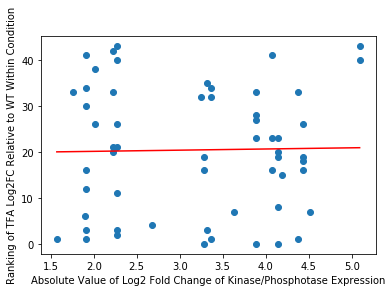

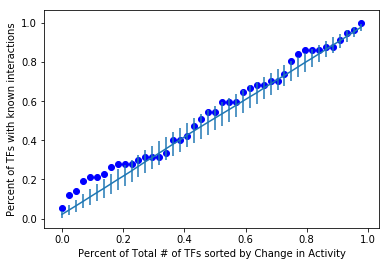

In [5]:
normalizedMatrix  = TFAHelp.rankingChange(matrix)

#match interactions
interactionsFound = {x[0]:-1 for x in expectedResults}
for tf in range(len(normalizedMatrix)-1):
    for kinase in range(len(normalizedMatrix[tf])):
        if kinases[kinase]+"_"+TFs[tf] in interactions:
            interactionsFound[kinases[kinase]+"_"+TFs[tf]] = normalizedMatrix[tf][kinase]
uniqueInteractions = [inter for inter in interactions]

GEImpact = {inter:-1 for inter in uniqueInteractions}
xvals = []
yvals = []
for inter in uniqueInteractions:
	kinase = inter.split("_")[0]
	kianseStdScore = np.abs(geneExpression[kinase]["ratio"][kinase])
	GEImpact[inter] = kianseStdScore
	xvals.append(abs(kianseStdScore))
	yvals.append(abs(interactionsFound[inter]))

plt.figure()
plt.scatter([abs(GEImpact[inter]) for inter in interactionsFound],[abs(interactionsFound[inter]) for inter in interactionsFound])
plt.xlabel("Absolute Value of Log2 Fold Change of Kinase/Phosphotase Expression")
plt.ylabel("Ranking of TFA Log2FC Relative to WT Within Condition")

positions = range(len(xvals))
positions.sort(key=lambda x: xvals[x])
xvals = [xvals[x] for x in positions]
yvals = [yvals[x] for x in positions]
slope,intercept,r,pvalue,_ = stats.linregress(xvals, yvals)
plt.plot(xvals,[x*slope+intercept for x in xvals],"r-")
print(r**2,pvalue)

###Generate Random Matrices to find Results:
plt.figure()

xcoords,ycoords = TFAHelp.expectedInteractionFallInRankingLevel(interactionsFound,len(normalizedMatrix)-1)
AUC = np.trapz(ycoords,dx = 1.0/(len(xcoords)-1))

plt.scatter(xcoords,ycoords,c="b")


nsims = 1000
allxCoords = []
allyCoords = []
AUCs = []
for _ in range(nsims):
    tempMat = TFAHelp.generateRandomMatrix([row[:-1] for row in matrix])
    tempMat = [tempMat[row] + [matrix[row][-1]] for row in range(len(tempMat))]
    tempNormMat = TFAHelp.rankingChange(tempMat)
    tempinteractionsFound = {x[0]:-1 for x in expectedResults}
    for tf in range(len(normalizedMatrix)-1):
        for kinase in range(len(normalizedMatrix[tf])):
            if kinases[kinase]+"_"+TFs[tf] in interactions:
                tempinteractionsFound[kinases[kinase]+"_"+TFs[tf]] = tempNormMat[tf][kinase]
    xcoords,ycoords = TFAHelp.expectedInteractionFallInRankingLevel(tempinteractionsFound,len(normalizedMatrix)-1)
    AUCs.append(np.trapz(ycoords,dx = 1.0/(len(xcoords)-1)))
    allxCoords.append(xcoords)
    allyCoords.append(ycoords)

AUCs.sort(reverse=True)
index = 0
for val in AUCs:
    if AUC > val:
        index -= 1
        break
    index+=1
percentile = float(index)/len(AUCs)

print(AUC,percentile)
    
plt.errorbar(x = xcoords,y = np.mean(allyCoords,axis = 0),
             yerr = np.std(allyCoords,axis=0))
    
plt.xlabel("Percent of Total # of TFs sorted by Change in Activity")
plt.ylabel("Percent of TFs with known interactions")




In [8]:
TFAHelp.writeMatrix2csv(normalizedMatrix,open("normalizedTFAMatrix.csv","w"))

In [1]:
#overall distribution and statistical test

plt.figure()
plt.hist(allInteractions, bins = 40)
plt.xlabel("Score")
plt.ylabel("Frequency")

a = len(significantFoundInteractions)
b = len(uniqueInteractions)-a
c = int(alpha*len(allInteractions)) - a
d = len(allInteractions) - a - b - c

print(stats.fisher_exact([[a,b],[c,d]],alternative = "greater"))


NameError: name 'plt' is not defined